# Modelo de Ising 2 Dimensões
### Rede Quadrada/Retângular com sitios centrais com 4, bordas com 3 e vertice com 2 vizinhos.


In [136]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

Quantidade de Linhas e colunas da rede, Quantidade de sitios := N = LC

In [137]:
#Numero de sitios := NxN
N = 10

### Gera uma rede de spins baseada no sorteio random.random

In [138]:
init_random = np.random.random((N,N))
rede_N = np.zeros((N, N))
rede_N[init_random>=0.5] = 1
rede_N[init_random<0.5] = -1

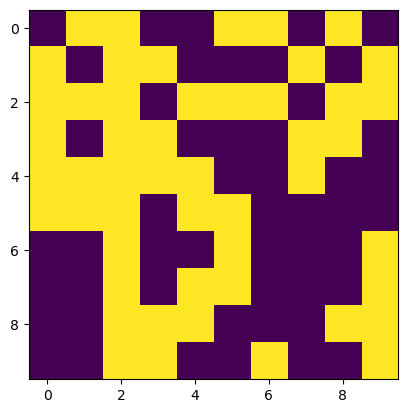

In [139]:
plt.imshow(rede_N)

### Define a Energia do sistema, é calcula a interação dos vizinhos.
### $\frac{Energia}{J} = -\sum_{ij}s_is_j$.

Falta a energia do campo $h_is_i$

In [140]:
def get_energy(rede):
    # aplica o somatório dos vizinhos mais próximos
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -rede * convolve(rede, kern, mode='constant', cval=0)
    return arr.sum()


In [141]:
get_energy(rede_N)

-24.0

# Escolhe um spin aleatorio gira, calcula a diferença de energia devido a esta nova configurarção dada por $s_i \rightarrow -s_i$

In [142]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. escolha um ponto aleatório na matriz e gira o flip
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #spin inicial
        spin_f = spin_i*-1  #spin girado
        
        # variação da energia
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. mudança
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy


C:\Users\joaop\anaconda3\lib\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [143]:
spins, energies = metropolis(rede_N, 5000, 10, get_energy(rede_N))

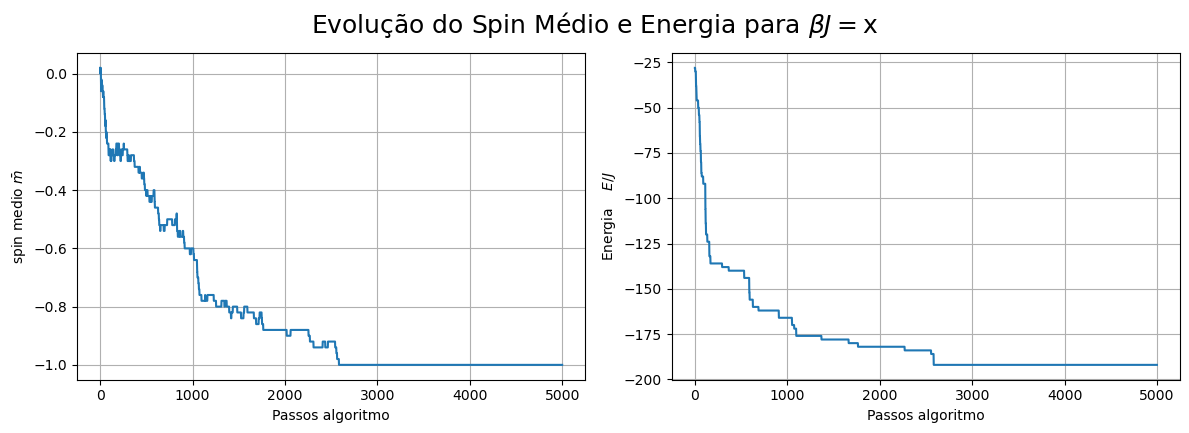

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Passos algoritmo')
ax.set_ylabel(r'spin medio $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Passos algoritmo')
ax.set_ylabel(r'Energia    $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolução do Spin Médio e Energia para $\beta J=$x', y=1.07, size=18)
plt.show()

In [145]:
def get_spin_energy(rede, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(rede, 1000000, bj, get_energy(rede))
        ms[i] = spins[-100000:].mean()/N**2
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
ms_p, E_means_n, E_stds_n = get_spin_energy(rede_N, BJs)


magnetização em função da temperatura $T=\frac{1}{\beta k}$

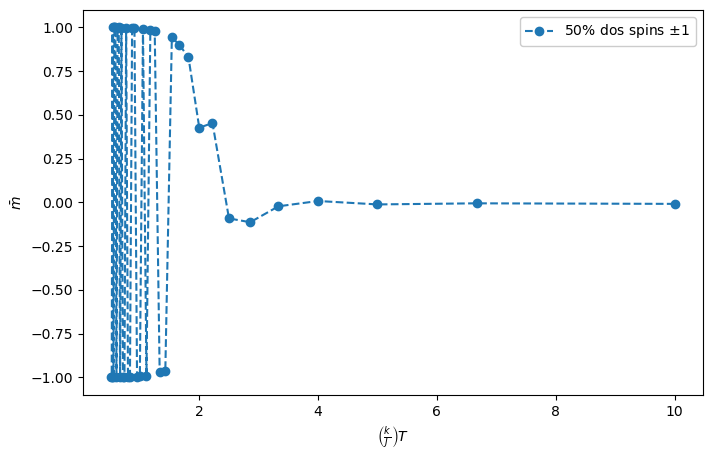

In [146]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_p, 'o--', label='50% dos spins $\pm1$')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()